# Taller Pto. 2

En la modalidad de préstamos en línea P2P no hay entrevista en persona y un prestatario
puede simplemente rellenar un formulario en línea y obtener la aprobación de un préstamo.
La información proporcionada únicamente por el prestatario es propensa a la exageración
y la distorsión. La mayor pregunta para toda empresa de préstamos P2P es si un usuario
incumplirá o no. El algoritmo para predecir la probabilidad de impago es el núcleo de un
negocio P2P y debe construirse con cuidado. Su tarea es construir un modelo de clasificación
para determinar si un usuario incumplirá su préstamo o no.

Se cuenta con la siguiente información:

* loan_status: Estado del préstamo
* annual_inc: Ingresos anuales del cliente
* verification_status: Estado de la verificación de los ingresos
* emp_length: Tiempo de empleado
* home_ownership: Tipo de vivienda
* int_rate: Tasa de interés del crédito
* loan_amnt: Monto del crédito
* purpose: Propósito del crédito
* term: Término del crédito
* grade: Calificación del cliente

## Librerías

In [2]:
#Advertencias
import warnings
warnings.filterwarnings('ignore')

#tratamiento de datos
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

#Preparación de datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn import set_config

#Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Evaluación
from sklearn.metrics import accuracy_score, confusion_matrix

## Cargue de datos

In [335]:
datos = pd.read_csv('lcc.csv')
datos.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B


## Exploaración de datos

In [8]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  object 
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


In [125]:
datos.describe(include='all')

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
count,81879,8.187900e+04,81879,81879,81879,81879.000000,81879.00000,81879,81879.000000,81879.000000
unique,2,NaN,3,11,4,NaN,NaN,14,NaN,NaN
top,Fully Paid,NaN,Verified,10+ years,RENT,NaN,NaN,debt_consolidation,NaN,NaN
freq,65254,NaN,34062,19731,38869,NaN,NaN,41239,NaN,NaN
mean,NaN,7.567183e+04,NaN,NaN,NaN,15.210047,13993.71878,NaN,47.187337,3.000000
std,NaN,6.126719e+04,NaN,NaN,NaN,4.743278,8795.90629,NaN,11.972524,2.000012
min,NaN,4.080000e+03,NaN,NaN,NaN,5.420000,500.00000,NaN,36.000000,0.000000
25%,NaN,4.500000e+04,NaN,NaN,NaN,11.710000,6600.00000,NaN,36.000000,1.000000
50%,NaN,6.382000e+04,NaN,NaN,NaN,15.620000,12000.00000,NaN,36.000000,3.000000
75%,NaN,9.099600e+04,NaN,NaN,NaN,19.040000,20000.00000,NaN,60.000000,5.000000


## Cálculo de la correlación

In [336]:
#Transformación de la y
datos['grade'].replace(to_replace='A', value=0, inplace=True)
datos['grade'].replace(to_replace='B', value=1, inplace=True)
datos['grade'].replace(to_replace='C', value=2, inplace=True)
datos['grade'].replace(to_replace='D', value=3, inplace=True)
datos['grade'].replace(to_replace='E', value=4, inplace=True)
datos['grade'].replace(to_replace='F', value=5, inplace=True)
datos['grade'].replace(to_replace='G', value=6, inplace=True)

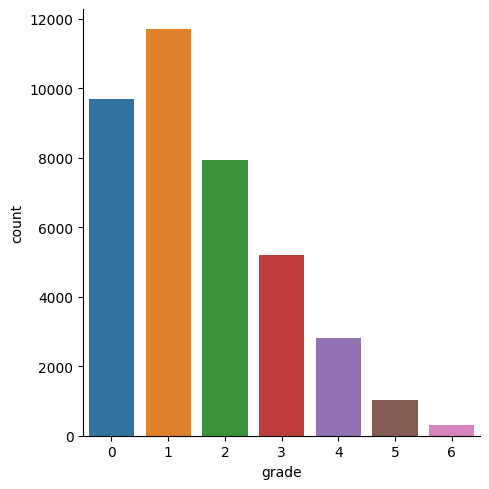

In [363]:
sb.catplot(data=datos, x='grade', kind='count')

In [344]:
#Modificación de variables
datos['int_rate'] = datos['int_rate'].replace({'%':''}, regex = True).astype(float)
datos['term'] = datos['term'].replace({'months':''}, regex = True).astype(int)

In [359]:
numCols = datos.select_dtypes(include = ['float64','int64', 'int32']).columns.to_list()
catCols = datos.select_dtypes(include = ['object']).columns.to_list()
catTransformer = Pipeline(steps = [('ordinal', OrdinalEncoder(handle_unknown = 'error'))])
ppAux = ColumnTransformer(transformers = [('cat', catTransformer, catCols)], remainder = 'passthrough')
ppAux

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['loan_status', 'verification_status',
                                  'emp_length', 'home_ownership', 'purpose'])])

In [360]:
auxData = ppAux.fit_transform(datos)
auxData

array([[1.0e+00, 2.0e+00, 1.0e+00, ..., 5.0e+03, 3.6e+01, 1.0e+00],
       [0.0e+00, 1.0e+00, 1.0e+01, ..., 2.5e+03, 6.0e+01, 2.0e+00],
       [1.0e+00, 0.0e+00, 1.0e+00, ..., 2.4e+03, 3.6e+01, 2.0e+00],
       ...,
       [1.0e+00, 0.0e+00, 1.0e+01, ..., 5.0e+03, 3.6e+01, 0.0e+00],
       [1.0e+00, 0.0e+00, 1.0e+01, ..., 5.0e+03, 3.6e+01, 0.0e+00],
       [1.0e+00, 0.0e+00, 1.0e+01, ..., 7.5e+03, 3.6e+01, 4.0e+00]])

In [361]:
codCat = ppAux.named_transformers_['cat']['ordinal'].get_feature_names_out(catCols)
labels = np.concatenate([codCat, numCols])
auxData = pd.DataFrame(auxData, columns = labels)
auxData

,loan_status,verification_status,emp_length,home_ownership,purpose,annual_inc,int_rate,loan_amnt,term,grade
0,1.0,2.0,1.0,3.0,1.0,24000.0,10.65,5000.0,36.0,1.0
1,0.0,1.0,10.0,3.0,0.0,30000.0,15.27,2500.0,60.0,2.0
2,1.0,0.0,1.0,3.0,11.0,12252.0,15.96,2400.0,36.0,2.0
3,1.0,1.0,1.0,3.0,9.0,49200.0,13.49,10000.0,36.0,2.0
4,1.0,1.0,0.0,3.0,9.0,80000.0,12.69,3000.0,60.0,1.0
...,...,...,...,...,...,...,...,...,...,...
38700,1.0,0.0,4.0,0.0,4.0,110000.0,8.07,2500.0,36.0,0.0
38701,1.0,0.0,3.0,3.0,1.0,18000.0,10.28,8500.0,36.0,2.0
38702,1.0,0.0,10.0,0.0,2.0,100000.0,8.07,5000.0,36.0,0.0
38703,1.0,0.0,10.0,0.0,9.0,200000.0,7.43,5000.0,36.0,0.0


In [362]:
auxData.corr()

,loan_status,verification_status,emp_length,home_ownership,purpose,annual_inc,int_rate,loan_amnt,term,grade
loan_status,1.000000,-0.043782,0.006689,-0.023700,-0.040767,0.038905,-0.200111,-0.053193,-0.151221,-0.193650
verification_status,-0.043782,1.000000,-0.032566,-0.082250,-0.034392,0.128609,0.214416,0.421443,0.260829,0.196053
emp_length,0.006689,-0.032566,1.000000,0.073510,0.008734,-0.044886,-0.013219,-0.060109,-0.036984,-0.009452
home_ownership,-0.023700,-0.082250,0.073510,1.000000,0.027213,-0.196103,0.063349,-0.175567,-0.107107,0.053509
purpose,-0.040767,-0.034392,0.008734,0.027213,1.000000,0.000671,-0.012213,-0.124094,-0.034283,-0.005104
annual_inc,0.038905,0.128609,-0.044886,-0.196103,0.000671,1.000000,0.050614,0.268672,0.046435,0.052457
int_rate,-0.200111,0.214416,-0.013219,0.063349,-0.012213,0.050614,1.000000,0.308663,0.453779,0.948552
loan_amnt,-0.053193,0.421443,-0.060109,-0.175567,-0.124094,0.268672,0.308663,1.000000,0.361222,0.289297
term,-0.151221,0.260829,-0.036984,-0.107107,-0.034283,0.046435,0.453779,0.361222,1.000000,0.432002
grade,-0.193650,0.196053,-0.009452,0.053509,-0.005104,0.052457,0.948552,0.289297,0.432002,1.000000


int_rate es la variable más estrechamente relacionada con grade, luego le siguen term y loan_amnt

## Preparación de los datos

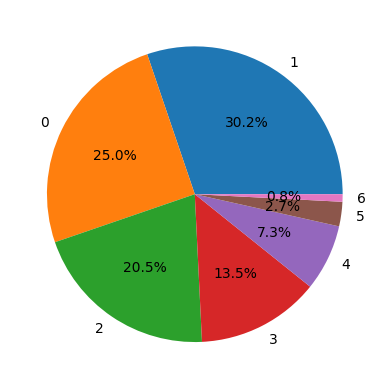

In [365]:
plt.pie(x = datos.grade.value_counts(), labels = datos.grade.value_counts().index, autopct = '%0.1f%%')
plt.show()

In [441]:
datosA = datos[datos['grade'] == 0]
datosB = datos[datos['grade'] == 1]
datosC = datos[datos['grade'] == 2]
datosD = datos[datos['grade'] == 3]
datosE = datos[datos['grade'] == 4]
datosF = datos[datos['grade'] == 5]
datosG = datos[datos['grade'] == 6]

In [442]:
print('A =', datosA.shape)
print('B =', datosB.shape)
print('C =', datosC.shape)
print('D =', datosD.shape)
print('E =', datosE.shape)
print('F =', datosF.shape)
print('G =', datosG.shape)

A = (9694, 10)
B = (11697, 10)
C = (7938, 10)
D = (5213, 10)
E = (2811, 10)
F = (1035, 10)
G = (317, 10)


In [443]:
datosA = datosA.sample(datosB.shape[0], replace=True)

In [444]:
datosA.shape

(11697, 10)

In [445]:
datosC = datosC.sample(datosB.shape[0], replace=True)
datosD = datosD.sample(datosB.shape[0], replace=True)
datosE = datosE.sample(datosB.shape[0], replace=True)
datosF = datosF.sample(datosB.shape[0], replace=True)
datosG = datosG.sample(datosB.shape[0], replace=True)

In [446]:
print('A =', datosA.shape)
print('B =', datosB.shape)
print('C =', datosC.shape)
print('D =', datosD.shape)
print('E =', datosE.shape)
print('F =', datosF.shape)
print('G =', datosG.shape)

A = (11697, 10)
B = (11697, 10)
C = (11697, 10)
D = (11697, 10)
E = (11697, 10)
F = (11697, 10)
G = (11697, 10)


In [447]:
datos = pd.concat([datosA, datosB, datosC, datosD, datosE, datosF, datosG])

In [448]:
datos.shape

(81879, 10)

In [449]:
datos

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
7915,Fully Paid,79000.0,Not Verified,4 years,MORTGAGE,5.99,8000,debt_consolidation,36,0
35679,Fully Paid,85000.0,Verified,10+ years,MORTGAGE,9.32,10400,medical,36,0
14637,Fully Paid,36000.0,Verified,10+ years,RENT,5.99,6400,debt_consolidation,36,0
2278,Fully Paid,32000.0,Not Verified,4 years,RENT,7.51,12000,credit_card,36,0
15219,Fully Paid,76663.0,Not Verified,9 years,RENT,7.49,12000,debt_consolidation,36,0
...,...,...,...,...,...,...,...,...,...,...
23353,Fully Paid,42000.0,Source Verified,10+ years,OWN,20.03,13000,debt_consolidation,60,6
19864,Fully Paid,225000.0,Verified,10+ years,MORTGAGE,20.85,25000,credit_card,60,6
24667,Charged Off,203000.0,Verified,10+ years,RENT,21.64,25000,renewable_energy,36,6
3212,Fully Paid,120000.0,Verified,10+ years,MORTGAGE,22.74,35000,house,60,6


In [120]:
x = datos.drop('grade', axis=1)
y = datos[['grade']]

In [121]:
x.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term
7715,Fully Paid,60000.0,Not Verified,5 years,MORTGAGE,7.49,7000,credit_card,36
38459,Fully Paid,29376.0,Not Verified,1 year,RENT,7.43,2800,moving,36
19557,Fully Paid,40000.0,Verified,3 years,RENT,6.92,11800,debt_consolidation,36
8984,Fully Paid,32000.0,Not Verified,2 years,RENT,7.49,1500,major_purchase,36
9457,Fully Paid,26400.0,Not Verified,1 year,RENT,7.49,10000,debt_consolidation,36


In [117]:
y

,grade
7715,0
38459,0
19557,0
8984,0
9457,0
...,...
7504,6
17671,6
27734,6
13920,6


In [136]:
numCols = x.select_dtypes(include = ['float64','int64', 'int32']).columns.to_list()
catCols = x.select_dtypes(include = ['object']).columns.to_list()
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])
catTransformer = Pipeline(steps = [('ordinal', OrdinalEncoder(handle_unknown = 'error'))])
preprocesador = ColumnTransformer(transformers = [
    ('num', numTransformer, numCols), 
    ('cat', catTransformer, catCols)], 
                                  remainder = 'passthrough')
set_config(display = 'diagram')
preprocesador

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['annual_inc', 'int_rate', 'loan_amnt',
                                  'term']),
                                ('cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['loan_status', 'verification_status',
                                  'emp_length', 'home_ownership', 'purpose'])])

In [140]:
Xpre = preprocesador.fit_transform(x)
Xpre

array([[9.32634191e-03, 1.07981221e-01, 1.88405797e-01, ...,
        5.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.21886883e-03, 1.04851330e-01, 6.66666667e-02, ...,
        0.00000000e+00, 3.00000000e+00, 8.00000000e+00],
       [5.99074037e-03, 7.82472613e-02, 3.27536232e-01, ...,
        3.00000000e+00, 3.00000000e+00, 2.00000000e+00],
       ...,
       [1.22449933e-02, 8.07511737e-01, 5.65217391e-01, ...,
        1.00000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.93331465e-02, 7.66301513e-01, 9.94202899e-01, ...,
        1.00000000e+01, 3.00000000e+00, 2.00000000e+00],
       [2.45033289e-02, 7.66301513e-01, 7.10144928e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [141]:
codCat = preprocesador.named_transformers_['cat']['ordinal'].get_feature_names_out(catCols)
labels = np.concatenate([numCols, codCat])
Xpro = pd.DataFrame(Xpre, columns = labels)
Xpro

,annual_inc,int_rate,loan_amnt,term,loan_status,verification_status,emp_length,home_ownership,purpose
0,0.009326,0.107981,0.188406,0.0,1.0,0.0,5.0,0.0,1.0
1,0.004219,0.104851,0.066667,0.0,1.0,0.0,0.0,3.0,8.0
2,0.005991,0.078247,0.327536,0.0,1.0,2.0,3.0,3.0,2.0
3,0.004656,0.107981,0.028986,0.0,1.0,0.0,2.0,3.0,6.0
4,0.003723,0.107981,0.275362,0.0,1.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...
81874,0.026004,0.909233,0.893478,1.0,1.0,2.0,10.0,3.0,2.0
81875,0.008780,0.804903,0.449275,1.0,1.0,2.0,1.0,0.0,2.0
81876,0.012245,0.807512,0.565217,1.0,1.0,1.0,10.0,0.0,2.0
81877,0.019333,0.766302,0.994203,1.0,1.0,1.0,10.0,3.0,2.0


## Regresión logísitca con una variable

In [256]:
X_train, X_test, Y_train, Y_test = train_test_split(Xpro[['int_rate']], y, train_size = 0.7, random_state = 123)

In [257]:
# Regresión logística
modelo_1 = LogisticRegression()
modelo_1.fit(X_train, Y_train)

LogisticRegression()

In [258]:
# Traer información
modelo_1.intercept_

array([ 24.08320006,  18.03694675,   9.65766233,   0.94108067,
        -7.50323609, -17.50734402, -27.7083097 ])

In [259]:
modelo_1.coef_

array([[-64.99203395],
       [-34.88437645],
       [-11.64596752],
       [  6.59960005],
       [ 21.00442284],
       [ 35.47455751],
       [ 48.44379752]])

0.6706970252115502


<function matplotlib.pyplot.show(close=None, block=None)>

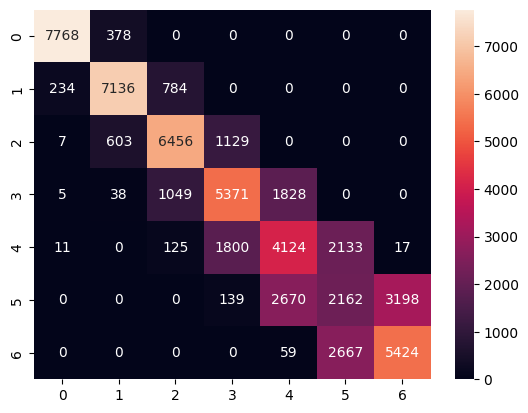

In [260]:
# Modelo 1: entrenamiento

pred_train_1 = modelo_1.predict(X_train)
pred_test_1 = modelo_1.predict(X_test)

acc_train_1 = accuracy_score(Y_train, pred_train_1)
print(acc_train_1)

mat_train_1 = confusion_matrix(Y_train, pred_train_1)
sb.heatmap(mat_train_1, annot = True, fmt = 'd')
plt.show

0.6764777723497801


<function matplotlib.pyplot.show(close=None, block=None)>

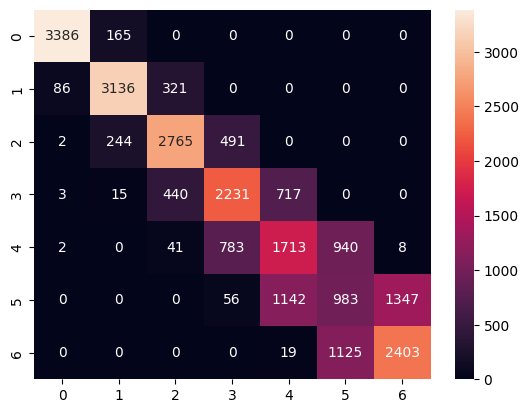

In [261]:
# Modelo 1: prueba

acc_test_1 = accuracy_score(Y_test, pred_test_1)
print(acc_test_1)

mat_test_1 = confusion_matrix(Y_test, pred_test_1)
sb.heatmap(mat_test_1, annot = True, fmt = 'd')
plt.show

## Regresión logística con todas las variables

In [262]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xpro, y, train_size = 0.7, random_state = 123)

In [263]:
# Regresión logística
modelo_2 = LogisticRegression()
modelo_2.fit(X2_train, Y2_train)

LogisticRegression()

In [264]:
modelo_2.intercept_

array([ 10.32777498,  10.83885797,   5.84816796,   0.87563281,
        -3.30064046,  -8.78030522, -15.80948803])

In [265]:
modelo_2.coef_

array([[ 4.09568940e-02, -4.34636871e+01, -3.88545200e+00,
        -1.01805956e+01,  5.20755987e+00,  3.23286419e-01,
         1.43386925e-01, -2.05303192e-01,  1.33867578e-01],
       [-1.73837719e-02, -1.88112832e+01, -1.21413029e+00,
         1.81727659e+00, -5.94793278e-01,  2.26226906e-01,
         2.34865954e-02, -5.37289430e-02,  3.95401204e-03],
       [ 5.16004163e-02, -5.24279608e+00, -3.03635611e-01,
         1.91197077e+00, -7.51899686e-01, -4.71470841e-02,
         2.82288110e-02,  4.94527189e-02, -2.41907756e-02],
       [-9.93903932e-02,  4.43572236e+00,  1.23184264e+00,
         1.73571758e+00, -6.66907745e-01, -1.59489506e-01,
        -1.50652236e-02,  1.59907805e-01, -4.51618579e-02],
       [-1.00293075e-02,  1.13152425e+01,  1.49266682e+00,
         2.09743005e+00, -9.47677436e-01, -3.06799156e-02,
        -3.19756640e-02,  1.32042494e-01, -4.60290180e-02],
       [-7.14890392e-03,  2.10023030e+01,  1.43242497e+00,
         1.68210671e+00, -1.11748329e+00, -2.177334

0.651592078862427


<function matplotlib.pyplot.show(close=None, block=None)>

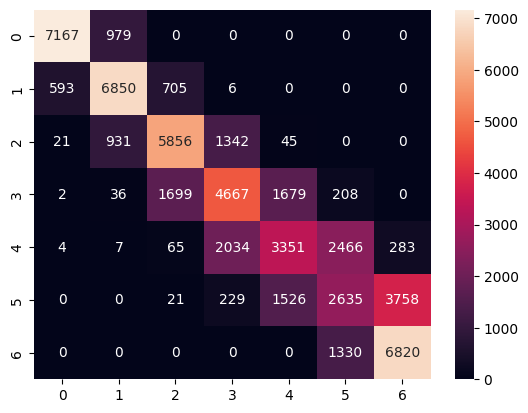

In [266]:
# Modelo 2: entrenamiento

pred_train_2 = modelo_2.predict(X2_train)
pred_test_2 = modelo_2.predict(X2_test)

acc_train_2 = accuracy_score(Y2_train, pred_train_2)
print(acc_train_2)

mat_train_2 = confusion_matrix(Y2_train, pred_train_2)
sb.heatmap(mat_train_2, annot = True, fmt = 'd')
plt.show

0.6577511805894806


<function matplotlib.pyplot.show(close=None, block=None)>

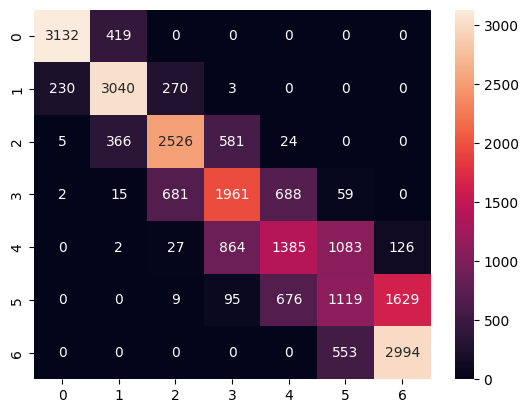

In [267]:
# Modelo 2: prueba

acc_test_2 = accuracy_score(Y2_test, pred_test_2)
print(acc_test_2)

mat_test_2 = confusion_matrix(Y2_test, pred_test_2)
sb.heatmap(mat_test_2, annot = True, fmt = 'd')
plt.show

## Maquina de soporte vectorial

In [288]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(Xpro[['int_rate','term','loan_amnt']], y, train_size = 0.7, random_state = 123)
modelo_3 = SVC()
modelo_3.fit(X3_train, Y3_train)

SVC()

In [289]:
modelo_3.C

1.0

Entrenamiento Modelo 3

0.7181715083311524


<function matplotlib.pyplot.show(close=None, block=None)>

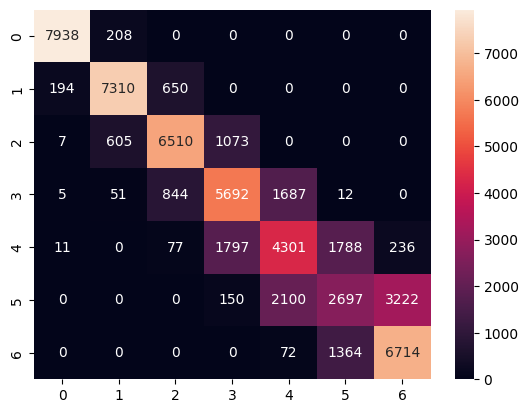

In [290]:
pred_train_3 = modelo_3.predict(X3_train)
pred_test_3 = modelo_3.predict(X3_test)

acc_train_3 = accuracy_score(Y3_train, pred_train_3)
print(acc_train_3)

mat_train_3 = confusion_matrix(Y3_train, pred_train_3)
sb.heatmap(mat_train_3, annot = True, fmt = 'd')
plt.show

Prueba Modelo 3

0.7241084513922814


<function matplotlib.pyplot.show(close=None, block=None)>

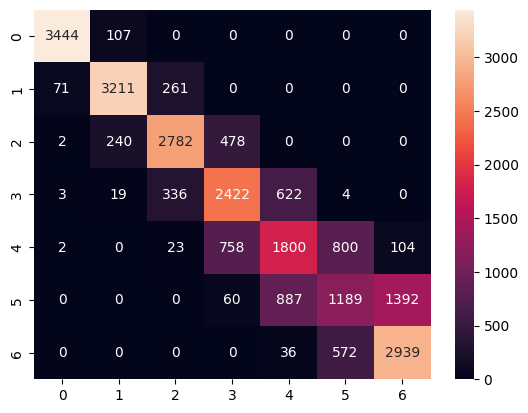

In [291]:
acc_test_3 = accuracy_score(Y3_test, pred_test_3)
print(acc_test_3)

mat_test_3 = confusion_matrix(Y3_test, pred_test_3)
sb.heatmap(mat_test_3, annot = True, fmt = 'd')
plt.show

## Red Neuronal

In [281]:
X4_train, X4_test, Y4_train, Y4_test = train_test_split(Xpro, y, train_size = 0.7, random_state = 123)
modelo_4 = MLPClassifier()
modelo_4.fit(X4_train, Y4_train)

MLPClassifier()

Entrenamiento modelo 4

0.7606734711681061


<function matplotlib.pyplot.show(close=None, block=None)>

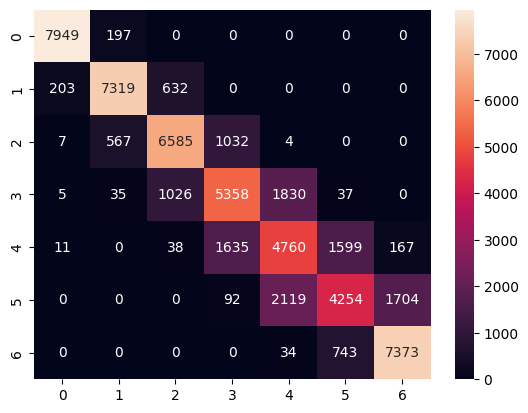

In [282]:
pred_train_4 = modelo_4.predict(X4_train)
pred_test_4 = modelo_4.predict(X4_test)

acc_train_4 = accuracy_score(Y4_train, pred_train_4)
print(acc_train_4)

mat_train_4 = confusion_matrix(Y4_train, pred_train_4)
sb.heatmap(mat_train_4, annot = True, fmt = 'd')
plt.show

Prueba modelo 4

0.7605031753786028


<function matplotlib.pyplot.show(close=None, block=None)>

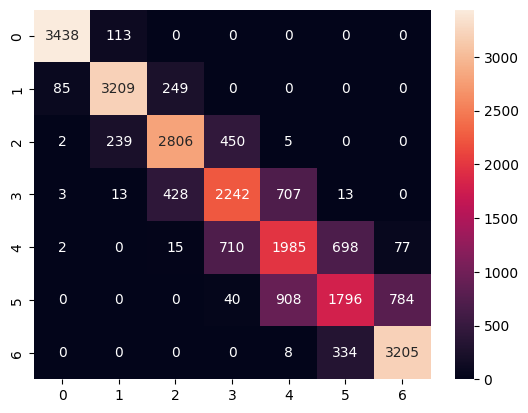

In [283]:
acc_test_4 = accuracy_score(Y4_test, pred_test_4)
print(acc_test_4)

mat_test_4 = confusion_matrix(Y4_test, pred_test_4)
sb.heatmap(mat_test_4, annot = True, fmt = 'd')
plt.show

## Conclusiones

Entre los 3 modelos utilizados, determinamos que para este caso, el mejor es la red neuronal artificial, dado el porcentaje de éxito que tuvo este en el proceso de clasificación durante el entrenamiento y la prueba.

# Taller Pto. 3

In [519]:
datos3 = pd.read_csv('lcc.csv')
datos3

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07%,2500,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28%,8500,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07%,5000,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43%,5000,other,36 months,A


In [520]:
#Transformación de la y
datos3['grade'].replace(to_replace='A', value=0, inplace=True)
datos3['grade'].replace(to_replace='B', value=1, inplace=True)
datos3['grade'].replace(to_replace='C', value=2, inplace=True)
datos3['grade'].replace(to_replace='D', value=3, inplace=True)
datos3['grade'].replace(to_replace='E', value=4, inplace=True)
datos3['grade'].replace(to_replace='F', value=5, inplace=True)
datos3['grade'].replace(to_replace='G', value=6, inplace=True)

In [521]:
#Modificación de variables
datos3['int_rate'] = datos3['int_rate'].replace({'%':''}, regex = True).astype(float)
datos3['term'] = datos3['term'].replace({'months':''}, regex = True).astype(int)

**Los grados de calificación se separan en 2 grupos, buenas califiaciones [A, C] y malas calificaciones [D, G]**

In [522]:
datos3['grade'] = np.where(datos3['grade']<3,1,0)

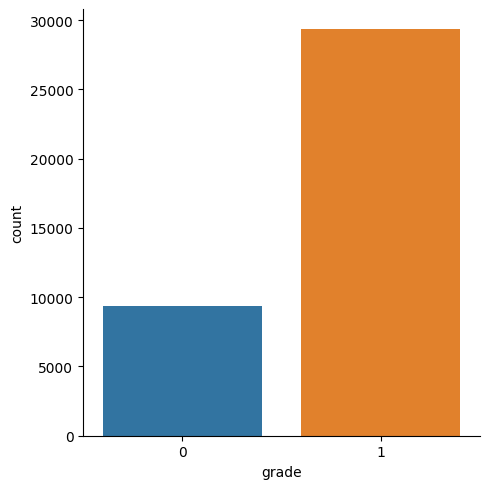

In [523]:
sb.catplot(data=datos3, x='grade', kind='count')

In [524]:
good = datos3[datos3['grade'] == 1]
bad = datos3[datos3['grade'] == 0]

In [525]:
good.shape

(29329, 10)

In [526]:
bad.shape

(9376, 10)

In [527]:
bad = bad.sample(good.shape[0], replace = True)
bad.shape

(29329, 10)

In [528]:
datos3 = pd.concat([good, bad])
datos3.shape

(58658, 10)

In [529]:
X = datos3[['verification_status']]
Y = datos3[['grade']]

In [530]:
##numCols = X.select_dtypes(include = ['float64','int64', 'int32']).columns.to_list()
##catCols = x.select_dtypes(include = ['object']).columns.to_list()
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preprocesador = ColumnTransformer(transformers = [('cat', catTransformer, ['verification_status'])],
                                  remainder = 'passthrough')
set_config(display = 'diagram')
preprocesador

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['verification_status'])])

In [531]:
Xpre = preprocesador.fit_transform(X)
Xpre

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [532]:
labels = preprocesador.named_transformers_['cat']['onehot'].get_feature_names_out(['verification_status'])
X3pro = pd.DataFrame(Xpre, columns = labels)
X3pro

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
58653,0.0,1.0,0.0
58654,0.0,0.0,1.0
58655,0.0,0.0,1.0
58656,0.0,0.0,1.0


In [533]:
# Separación en entrenamiento y prueba

X5_train, X5_test, Y5_train, Y5_test = train_test_split(X3pro[['verification_status_Source Verified']], Y, train_size = 0.7, random_state = 123)

## Regresión Logísitca

In [534]:
# Regresión logística
modelo_5 = LogisticRegression()
modelo_5.fit(X5_train, Y5_train)

LogisticRegression()

0.5074281539210911


<function matplotlib.pyplot.show(close=None, block=None)>

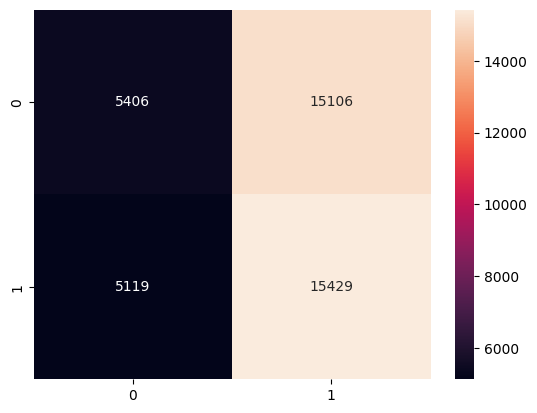

In [535]:
# Modelo 5: entrenamiento

pred_train_5 = modelo_5.predict(X5_train)
pred_test_5 = modelo_5.predict(X5_test)

acc_train_5 = accuracy_score(Y5_train, pred_train_5)
print(acc_train_5)

mat_train_5 = confusion_matrix(Y5_train, pred_train_5)
sb.heatmap(mat_train_5, annot = True, fmt = 'd')
plt.show

0.5045459711330833


<function matplotlib.pyplot.show(close=None, block=None)>

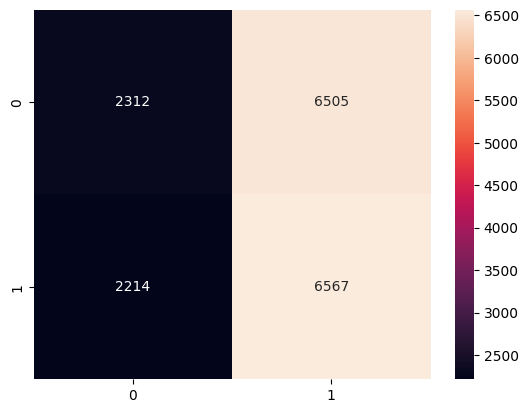

In [536]:
# Modelo 5: prueba

acc_test_5 = accuracy_score(Y5_test, pred_test_5)
print(acc_test_5)

mat_test_5 = confusion_matrix(Y5_test, pred_test_5)
sb.heatmap(mat_test_5, annot = True, fmt = 'd')
plt.show

## Máquina de soporte vectorial

In [537]:
modelo_6 = SVC()
modelo_6.fit(X5_train, Y5_train)

SVC()

Entrenamiento modelo 6

0.5074281539210911


<function matplotlib.pyplot.show(close=None, block=None)>

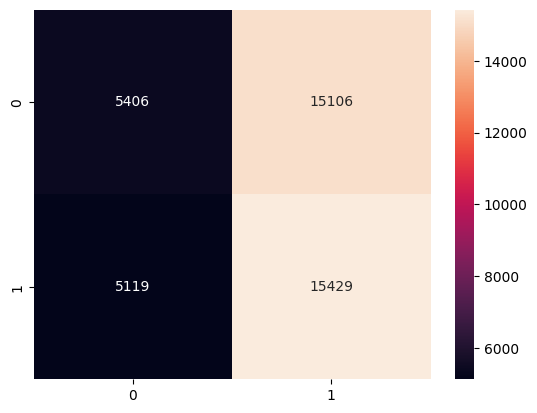

In [538]:
pred_train_6 = modelo_6.predict(X5_train)
pred_test_6 = modelo_6.predict(X5_test)

acc_train_6 = accuracy_score(Y5_train, pred_train_6)
print(acc_train_6)

mat_train_6 = confusion_matrix(Y5_train, pred_train_6)
sb.heatmap(mat_train_6, annot = True, fmt = 'd')
plt.show

Prueba modelo 6

0.5045459711330833


<function matplotlib.pyplot.show(close=None, block=None)>

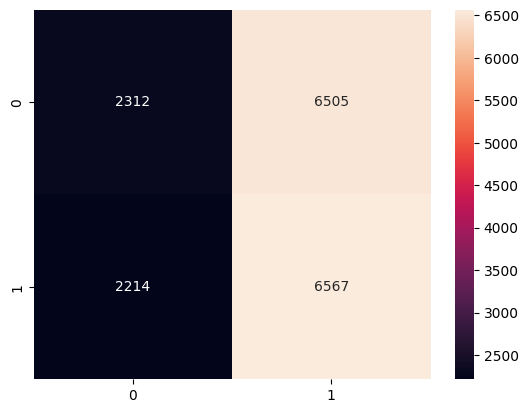

In [539]:
acc_test_6 = accuracy_score(Y5_test, pred_test_6)
print(acc_test_6)

mat_test_6 = confusion_matrix(Y5_test, pred_test_6)
sb.heatmap(mat_test_6, annot = True, fmt = 'd')
plt.show

## Red neuronal artificial

In [540]:
modelo_7 = MLPClassifier()
modelo_7.fit(X5_train, Y5_train)

MLPClassifier()

Entrenamiento modelo 7

0.4995616171456405


<function matplotlib.pyplot.show(close=None, block=None)>

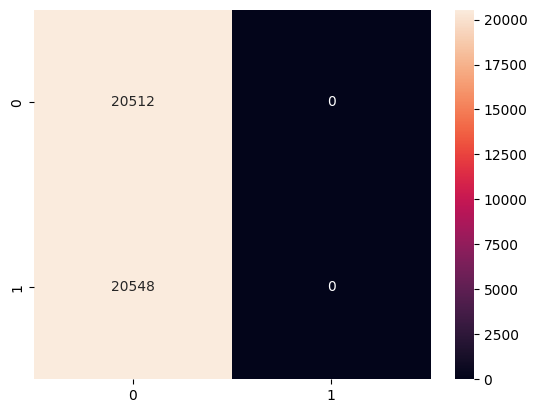

In [541]:
pred_train_7 = modelo_7.predict(X5_train)
pred_test_7 = modelo_7.predict(X5_test)

acc_train_7 = accuracy_score(Y5_train, pred_train_7)
print(acc_train_7)

mat_train_7 = confusion_matrix(Y5_train, pred_train_7)
sb.heatmap(mat_train_7, annot = True, fmt = 'd')
plt.show

Prueba modelo 7

0.5010228435049437


<function matplotlib.pyplot.show(close=None, block=None)>

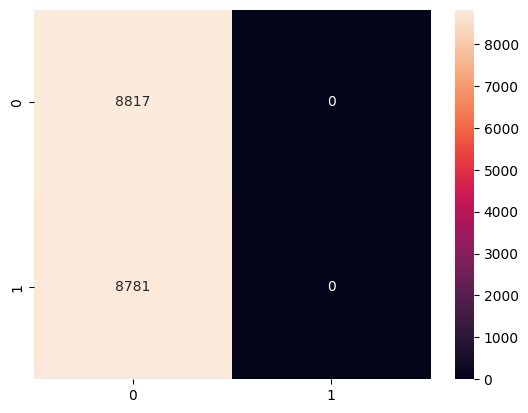

In [542]:
acc_test_7 = accuracy_score(Y5_test, pred_test_7)
print(acc_test_7)

mat_test_7 = confusion_matrix(Y5_test, pred_test_7)
sb.heatmap(mat_test_7, annot = True, fmt = 'd')
plt.show

## Conclusión

Bajo ninguno de los modelos aplicados, regresión logística, máquina de soporte vectorial y red neuronal artificial, se logró predecir satisfactoriamente la calificación del cliente en base a si la fuente de los ingresos estaba verificada o no, pues la rata de éxito en cada uno de ellos fue de aproximadamente el 50%. Por lo tanto se determina que la empresa no tendría por qué verificar la fuente de ingresos de los solicitantes de préstamos.